# **Load Data From Kaggle**

In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 70 bytes


In [2]:
!kaggle datasets download -d yasserh/imdb-movie-ratings-sentiment-analysis

 44% 9.00M/20.6M [00:00<00:00, 66.1MB/s]
100% 20.6M/20.6M [00:00<00:00, 115MB/s] 


In [3]:
from zipfile import ZipFile
file_name = "/content/imdb-movie-ratings-sentiment-analysis.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


# **Import Library it needed**

In [40]:
import pandas as pd
import numpy as np
import tensorflow as tf

import re
import nltk

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential
from keras.layers import Embedding, Dense, Bidirectional, Activation, GlobalMaxPool1D, GRU, LSTM, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
from keras.utils import plot_model

from google.colab import drive
from keras.models import load_model
import pickle

## **Read Data From CSV File**

In [6]:
dataset = pd.read_csv("/content/movie.csv")

Show the top 5 row in dataset

In [7]:
dataset.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


Visualize and Count Labels

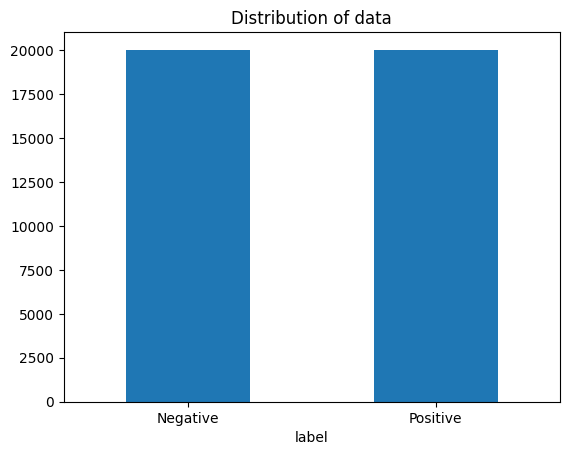

In [8]:
ax = dataset.groupby('label').count().plot(kind='bar', title='Distribution of data',
                                               legend=False)
ax = ax.set_xticklabels(['Negative','Positive'], rotation=0)

# **Data Preprocessing**

In [12]:
contractions = pd.read_csv('/content/drive/MyDrive/IMDB_Dataset/archive.zip', index_col='Contraction')
contractions.index = contractions.index.str.lower()
contractions.Meaning = contractions.Meaning.str.lower()
contractions_dict = contractions.to_dict()['Meaning']

# Defining regex patterns.
linebreaks        = "<br /><br />"
alphaPattern      = "[^a-z0-9<>]"
sequencePattern   = r"(.)\1\1+"
seqReplacePattern = r"\1\1"

# Defining regex for emojis
smileemoji        = r"[8:=;]['`\-]?[)d]+"
sademoji          = r"[8:=;]['`\-]?\(+"
neutralemoji      = r"[8:=;]['`\-]?[\/|l*]"
lolemoji          = r"[8:=;]['`\-]?p+"

def preprocess_reviews(review):

    review = review.lower()

    review = re.sub(linebreaks," ",review)
    # Replace 3 or more consecutive letters by 2 letter.
    review = re.sub(sequencePattern, seqReplacePattern, review)

    # Replace all emojis.
    review = re.sub(r'<3', '<heart>', review)
    review = re.sub(smileemoji, '<smile>', review)
    review = re.sub(sademoji, '<sadface>', review)
    review = re.sub(neutralemoji, '<neutralface>', review)
    review = re.sub(lolemoji, '<lolface>', review)

    for contraction, replacement in contractions_dict.items():
        review = review.replace(contraction, replacement)

    # Remove non-alphanumeric and symbols
    review = re.sub(alphaPattern, ' ', review)

    # Adding space on either side of '/' to seperate words (After replacing URLS).
    review = re.sub(r'/', ' / ', review)
    return review

In [17]:
dataset['cleaned_review'] = dataset.text.apply(preprocess_reviews)

In [18]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [20]:
stop_words = set(stopwords.words('english'))
nltk.download('omw-1.4')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [21]:
dataset["cleaned_review"][0]

'i grew up  b  1965  watching and loving the thunderbirds  all my mates at school watched  we played  thunderbirds  before school  during lunch and after school  we all wanted to be virgil or scott  no one wanted to be alan  counting down from 5 became an art form  i took my children to see the movie hoping they would get a glimpse of what i loved as a child  how bitterly disappointing  the only high point was the snappy theme tune  not that it could compare with the original score of the thunderbirds  thankfully early saturday mornings one television channel still plays reruns of the series gerry anderson and his wife created  jonatha frakes should hand in his directors chair  his version was completely hopeless  a waste of film  utter rubbish  a cgi remake may be acceptable but replacing marionettes with homo sapiens subsp  sapiens was a huge error of judgment '

In [22]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [23]:
for i in range(len(dataset)):
    lis = []
    for words in dataset["cleaned_review"][i].split():
        if words not in stop_words:
            words = lemmatizer.lemmatize(words)
            lis.append(words)
    dataset["cleaned_review"][i] = " ".join(lis)

<ipython-input-23-a1d7b3398b7b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["cleaned_review"][i] = " ".join(lis)


In [24]:
print(dataset["cleaned_review"][69])

kennan ivory wayans funny low dirty shame see one one worst done steven seagal help much start odd religious killing make much sense jim campbell keenan surprised see new partner waiting work side crack case jack cole seem everyone think jackis ex wife killed one ritual killing end making suspect well thing movie smoke past cia involvement trying normal cop steven dress like western movie prayer beeds top make thing little confusing


In [26]:
data_pos = dataset[dataset["label"]==1]["cleaned_review"]
data_neg = dataset[dataset["label"]==0]["cleaned_review"]

In [27]:
X_data, y_data = np.array(dataset['cleaned_review']), np.array(dataset['label'])

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data,
                                                    test_size = 0.05, random_state = 0)
print('Data Split done.')

Data Split done.


In [28]:
Embedding_dimensions = 100

# Creating Word2Vec training dataset.
Word2vec_train_data = list(map(lambda x: x.split(), X_train))

In [29]:
# Defining the model and training it.
word2vec_model = Word2Vec(Word2vec_train_data,
                 vector_size=Embedding_dimensions,
                 workers=8,
                 min_count=5)

print("Vocabulary Length:", len(word2vec_model.wv.key_to_index))

Vocabulary Length: 32781


In [31]:
input_length = 750
vocab_length = 35000

tokenizer = Tokenizer(filters="", lower=False, oov_token="<oov>")
tokenizer.fit_on_texts(X_data)
tokenizer.num_words = vocab_length
print("Tokenizer vocab length:", vocab_length)

Tokenizer vocab length: 35000


In [32]:
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=input_length)
X_test  = pad_sequences(tokenizer.texts_to_sequences(X_test) , maxlen=input_length)

print("X_train.shape:", X_train.shape)
print("X_test.shape :", X_test.shape)

X_train.shape: (38000, 750)
X_test.shape : (2000, 750)


In [33]:
embedding_matrix = np.zeros((vocab_length, Embedding_dimensions))

for word, token in tokenizer.word_index.items():
    if word2vec_model.wv.__contains__(word):
        embedding_matrix[token] = word2vec_model.wv.__getitem__(word)

print("Embedding Matrix Shape:", embedding_matrix.shape)

Embedding Matrix Shape: (35000, 100)


# Pre-Trained Models

**1) LSTM**

In [ ]:
def getModel_LSTM():
    embedding_layer = Embedding(input_dim = vocab_length,
                                output_dim = Embedding_dimensions,
                                weights=[embedding_matrix],
                                input_length=input_length,
                                trainable=False)

    model = Sequential([
        embedding_layer,
        LSTM(64,return_sequences=True),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(1,activation="sigmoid")
    ],
    name="Sentiment_Model_LSTM")
    return model
training_model_LSTM= getModel_LSTM()

In [ ]:
training_model_LSTM.summary()

Model: "Sentiment_Model_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 750, 100)          3500000   
                                                                 
 lstm_2 (LSTM)               (None, 750, 64)           42240     
                                                                 
 dropout_2 (Dropout)         (None, 750, 64)           0         
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3554689 (13.56 MB)
Trainable par

In [ ]:
training_model_LSTM.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',
                                                                                tf.keras.metrics.AUC(),
                                                                                tf.keras.metrics.Recall(),
                                                                                tf.keras.metrics.Precision(),
                                                                                tf.keras.metrics.FalseNegatives(),
                                                                                tf.keras.metrics.FalsePositives(),
                                                                                tf.keras.metrics.TrueNegatives(),
                                                                                tf.keras.metrics.TruePositives(),
                                                                                tf.keras.metrics.F1Score()
                                                                                  ])

In [ ]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
             EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [ ]:
# Print some information about data
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("Sample X_train:", X_train[0])
print("Sample y_train:", y_train[0])


In [ ]:
tf.config.run_functions_eagerly(True)

In [ ]:
# Assuming y_train is label data
y_train = y_train.astype('float32')

In [ ]:
history_LSTM = training_model_LSTM.fit(
    X_train, y_train,
    batch_size=1024,
    epochs=20,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1,
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


34/34 [==============================] - 864s 25s/step - loss: 0.5173 - accuracy: 0.7469 - auc_1: 0.8246 - recall_1: 0.7461 - precision_1: 0.7455 - false_negatives_1: 4321.0000 - false_positives_1: 4334.0000 - true_negatives_1: 12850.0000 - true_positives_1: 12695.0000 - f1_score: 0.6645 - val_loss: 0.4270 - val_accuracy: 0.8053 - val_auc_1: 0.8950 - val_recall_1: 0.8703 - val_precision_1: 0.7781 - val_false_negatives_1: 254.0000 - val_false_positives_1: 486.0000 - val_true_negatives_1: 1356.0000 - val_true_positives_1: 1704.0000 - val_f1_score: 0.6801 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - 872s 25s/step - loss: 0.3748 - accuracy: 0.8414 - auc_1: 0.9135 - recall_1: 0.8490 - precision_1: 0.8349 - false_negatives_1: 2569.0000 - false_positives_1: 2856.0000 - true_negatives_1: 14328.0000 - true_positives_1: 14447.0000 - f1_score: 0.6645 - val_loss: 0.3389 - val_accuracy: 0.8529 - val_auc_1: 0.9349 - val_recall_1: 0.9055 - val_precision_1: 0.8258 - val_false_negat

In [ ]:
# Predicting on the Test dataset.
# y_pred_LSTM = training_model_LSTM.predict(X_test)
y_pred_LSTM = loaded_model_LSTM.predict(X_test)

# Converting prediction to reflect the sentiment predicted.
# y_pred_LSTM = np.where(y_pred_LSTM>=0.5, 1, 0)
y_pred_LSTM = np.where(y_pred_LSTM>=0.5, 1, 0)

63/63 [==============================] - 3s 20ms/step


In [ ]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred_LSTM)
precision = precision_score(y_test, y_pred_LSTM)
recall = recall_score(y_test, y_pred_LSTM)
f1 = f1_score(y_test, y_pred_LSTM)
conf_matrix = confusion_matrix(y_test, y_pred_LSTM)

# Print the metrics
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

print('confusion_matrix:',conf_matrix)

Accuracy: 0.89
Precision: 0.91
Recall: 0.88
F1 Score: 0.89
confusion_matrix: [[901  92]
 [121 886]]


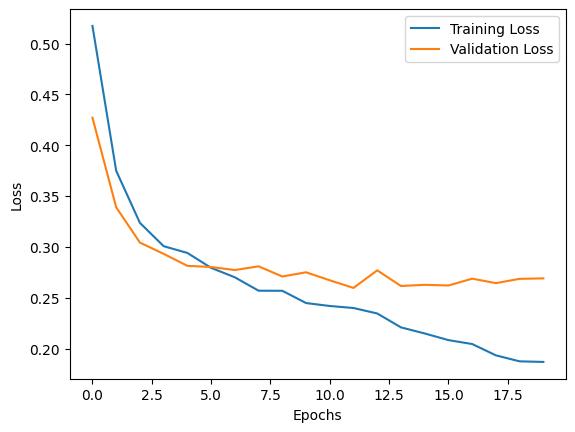

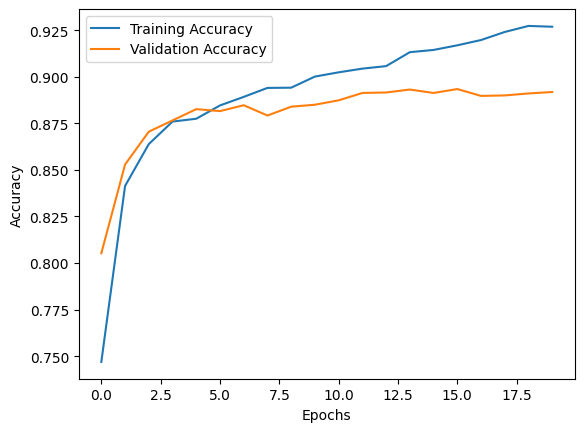

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have the 'history' object
loss = history_LSTM.history['loss']
val_loss = history_LSTM.history['val_loss']
acc = history_LSTM.history['accuracy']
val_acc = history_LSTM.history['val_accuracy']

# Plotting loss
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting accuracy
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


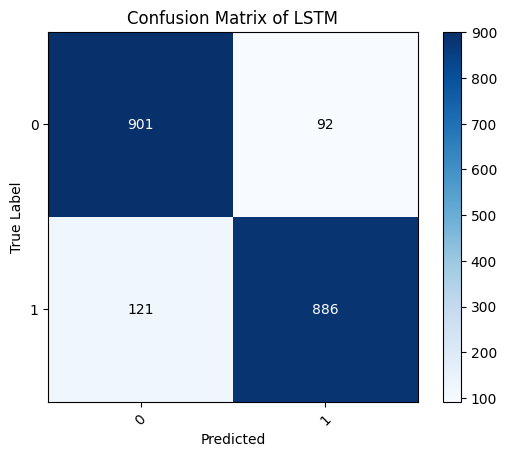

In [ ]:
class_names = ['0', '1']

# Plot the confusion matrix
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix of LSTM')
plt.colorbar()

# Add labels
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

# Add text annotations
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, str(conf_matrix[i, j]), ha='center', va='center', color='white' if conf_matrix[i, j] > conf_matrix.max() / 2 else 'black')

plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.show()

**2) LSTM**(Bideractional)

In [ ]:
def getModel_Bideractional():
    embedding_layer = Embedding(input_dim = vocab_length,
                                output_dim = Embedding_dimensions,
                                weights=[embedding_matrix],
                                input_length=input_length,
                                trainable=False)

    model = Sequential([
        embedding_layer,
        Bidirectional(LSTM(35,return_sequences=True)),
        GlobalMaxPool1D(),
        Dense(40, activation="relu"),
        Dropout(0.5),
        Dense(20, activation="relu"),
        Dropout(0.5),
        Dense(1, activation="sigmoid"),
    ],
    name="Sentiment_Model_LSTM_Bidirectional")
    return model

training_model_Bideractional= getModel_Bideractional()

In [ ]:
training_model_Bideractional.summary()

Model: "Sentiment_Model_LSTM_Bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 750, 100)          3500000   
                                                                 
 bidirectional (Bidirection  (None, 750, 70)           38080     
 al)                                                             
                                                                 
 global_max_pooling1d (Glob  (None, 70)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 40)                2840      
                                                                 
 dropout (Dropout)           (None, 40)                0         
                                                                 
 dense_1 (Dense)             (No

In [ ]:
training_model_Bideractional.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',
                                                                                            tf.keras.metrics.AUC(),
                                                                                            tf.keras.metrics.Recall(),
                                                                                            tf.keras.metrics.Precision(),
                                                                                            tf.keras.metrics.FalseNegatives(),
                                                                                            tf.keras.metrics.FalsePositives(),
                                                                                            tf.keras.metrics.TrueNegatives(),
                                                                                            tf.keras.metrics.TruePositives(),
                                                                                            tf.keras.metrics.F1Score()
                                                                                            ])

In [ ]:
history_Bideractional= training_model_Bideractional.fit(
    X_train, y_train,
    batch_size=1024,
    epochs=20,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1,
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


34/34 [==============================] - 915s 27s/step - loss: 0.6502 - accuracy: 0.6132 - auc: 0.6639 - recall: 0.5783 - precision: 0.6191 - false_negatives: 7176.0000 - false_positives: 6053.0000 - true_negatives: 11131.0000 - true_positives: 9840.0000 - f1_score: 0.6645 - val_loss: 0.5215 - val_accuracy: 0.8205 - val_auc: 0.8942 - val_recall: 0.8253 - val_precision: 0.8262 - val_false_negatives: 342.0000 - val_false_positives: 340.0000 - val_true_negatives: 1502.0000 - val_true_positives: 1616.0000 - val_f1_score: 0.6801 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - 762s 22s/step - loss: 0.4816 - accuracy: 0.7842 - auc: 0.8597 - recall: 0.7943 - precision: 0.7770 - false_negatives: 3500.0000 - false_positives: 3879.0000 - true_negatives: 13305.0000 - true_positives: 13516.0000 - f1_score: 0.6645 - val_loss: 0.3402 - val_accuracy: 0.8571 - val_auc: 0.9361 - val_recall: 0.8907 - val_precision: 0.8413 - val_false_negatives: 214.0000 - val_false_positives: 329.0000 - 

In [ ]:
# Predicting on the Test dataset.
# y_pred_LSTM = training_model_LSTM.predict(X_test)
y_pred_Bideractional = training_model_Bideractional.predict(X_test)

# Converting prediction to reflect the sentiment predicted.
# y_pred_LSTM = np.where(y_pred_LSTM>=0.5, 1, 0)
y_pred_Bideractional = np.where(y_pred_Bideractional>=0.5, 1, 0)

In [ ]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred_Bideractional)
precision = precision_score(y_test, y_pred_Bideractional)
recall = recall_score(y_test, y_pred_Bideractional)
f1 = f1_score(y_test, y_pred_Bideractional)
conf_matrix = confusion_matrix(y_test, y_pred_Bideractional)

# Print the metrics
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

Accuracy: 0.90
Precision: 0.91
Recall: 0.88
F1 Score: 0.90
Confusion Matrix:
[[903  90]
 [116 891]]


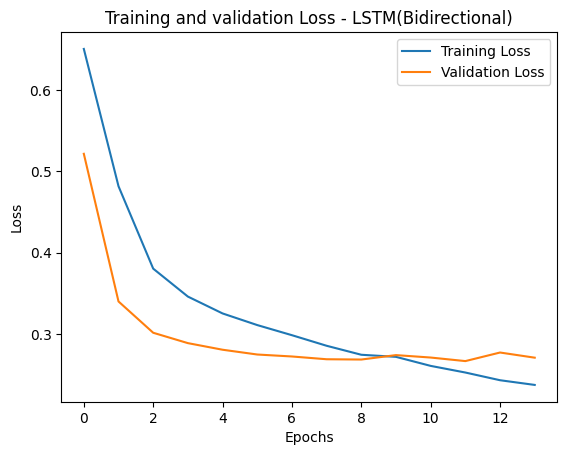

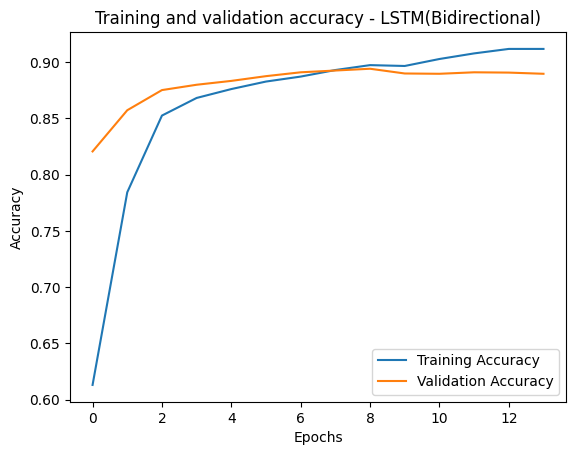

In [ ]:
# Assuming you have the 'history' object
loss = history_Bideractional.history['loss']
val_loss = history_Bideractional.history['val_loss']
acc = history_Bideractional.history['accuracy']
val_acc = history_Bideractional.history['val_accuracy']

# Plotting loss
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and validation Loss - LSTM(Bidirectional)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting accuracy
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and validation accuracy - LSTM(Bidirectional)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

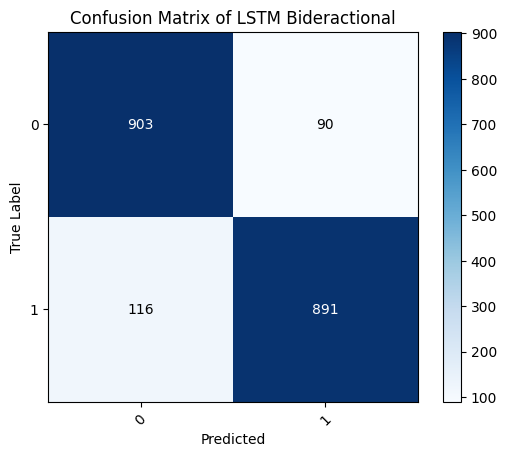

In [ ]:
class_names = ['0', '1']

# Plot the confusion matrix
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix of LSTM Bideractional')
plt.colorbar()

# Add labels
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

# Add text annotations
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, str(conf_matrix[i, j]), ha='center', va='center', color='white' if conf_matrix[i, j] > conf_matrix.max() / 2 else 'black')

plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.show()

**3) GRU**

In [ ]:
def getModel_GRU():
    embedding_layer = Embedding(input_dim = vocab_length,
                                output_dim = Embedding_dimensions,
                                weights=[embedding_matrix],
                                input_length=input_length,
                                trainable=False)

    model = Sequential([
        embedding_layer,
        GRU(32,return_sequences=False),
        Dense(24, activation='relu'),
        Dense(1,activation="sigmoid")
    ],
    name="Sentiment_Model_GRU")
    return model
training_model_GRU= getModel_GRU()

In [ ]:
training_model_GRU.summary()

Model: "Sentiment_Model_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 750, 100)          3500000   
                                                                 
 gru_4 (GRU)                 (None, 32)                12864     
                                                                 
 dense_11 (Dense)            (None, 24)                792       
                                                                 
 dense_12 (Dense)            (None, 1)                 25        
                                                                 
Total params: 3513681 (13.40 MB)
Trainable params: 13681 (53.44 KB)
Non-trainable params: 3500000 (13.35 MB)
_________________________________________________________________


In [ ]:
training_model_GRU.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',
                                                                                tf.keras.metrics.AUC(),
                                                                                tf.keras.metrics.Recall(),
                                                                                tf.keras.metrics.Precision(),
                                                                                tf.keras.metrics.FalseNegatives(),
                                                                                tf.keras.metrics.FalsePositives(),
                                                                                tf.keras.metrics.TrueNegatives(),
                                                                                tf.keras.metrics.TruePositives(),
                                                                                tf.keras.metrics.F1Score()
                                                                                  ])

In [ ]:
callbacks = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    min_delta=0.005,
    patience=2,
    mode="auto",
    restore_best_weights=False)

In [ ]:
history_GRU = training_model_GRU.fit( X_train, y_train, batch_size=1024,epochs=20, validation_split=0.1, callbacks=callbacks,verbose=1,)

Epoch 1/20
34/34 [==============================] - 6s 101ms/step - loss: 0.6519 - accuracy: 0.6165 - auc_6: 0.6627 - recall_6: 0.5081 - precision_6: 0.6457 - false_negatives_6: 8371.0000 - false_positives_6: 4744.0000 - true_negatives_6: 12440.0000 - true_positives_6: 8645.0000 - f1_score: 0.6645 - val_loss: 0.5826 - val_accuracy: 0.6908 - val_auc_6: 0.7597 - val_recall_6: 0.7089 - val_precision_6: 0.6964 - val_false_negatives_6: 570.0000 - val_false_positives_6: 605.0000 - val_true_negatives_6: 1237.0000 - val_true_positives_6: 1388.0000 - val_f1_score: 0.6801
Epoch 2/20
34/34 [==============================] - 2s 71ms/step - loss: 0.5300 - accuracy: 0.7322 - auc_6: 0.8101 - recall_6: 0.7322 - precision_6: 0.7303 - false_negatives_6: 4557.0000 - false_positives_6: 4602.0000 - true_negatives_6: 12582.0000 - true_positives_6: 12459.0000 - f1_score: 0.6645 - val_loss: 0.4610 - val_accuracy: 0.7826 - val_auc_6: 0.8641 - val_recall_6: 0.7768 - val_precision_6: 0.7963 - val_false_negatives

In [ ]:
# Predicting on the Test dataset.
# y_pred_LSTM = training_model_LSTM.predict(X_test)
y_pred_GRU = training_model_GRU.predict(X_test)

# Converting prediction to reflect the sentiment predicted.
# y_pred_LSTM = np.where(y_pred_LSTM>=0.5, 1, 0)
y_pred_GRU = np.where(y_pred_GRU>=0.5, 1, 0)

In [ ]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred_GRU)
precision = precision_score(y_test, y_pred_GRU)
recall = recall_score(y_test, y_pred_GRU)
f1 = f1_score(y_test, y_pred_GRU)
conf_matrix = confusion_matrix(y_test, y_pred_GRU)

# Print the metrics
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

Accuracy: 0.89
Precision: 0.87
Recall: 0.92
F1 Score: 0.89


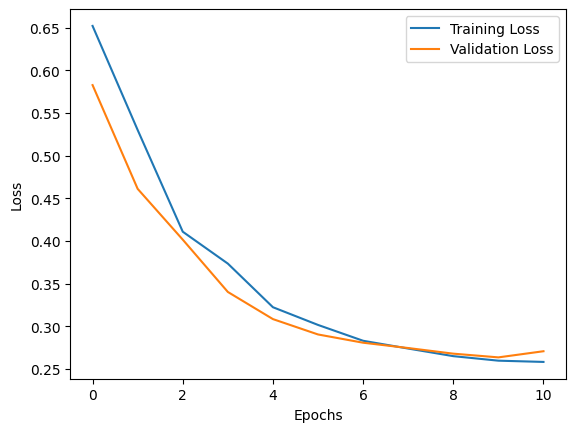

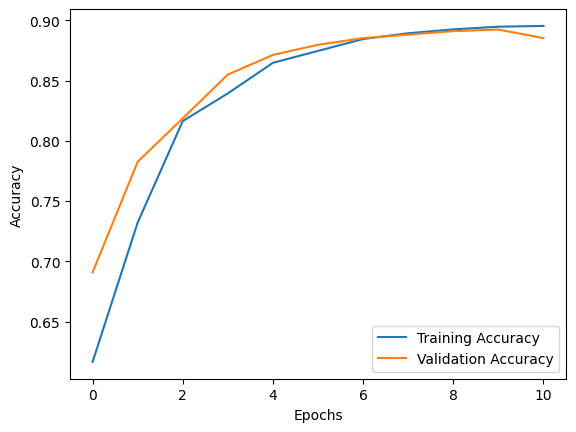

In [ ]:
# Assuming you have the 'history' object
loss = history_GRU.history['loss']
val_loss = history_GRU.history['val_loss']
acc = history_GRU.history['accuracy']
val_acc = history_GRU.history['val_accuracy']

# Plotting loss
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting accuracy
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


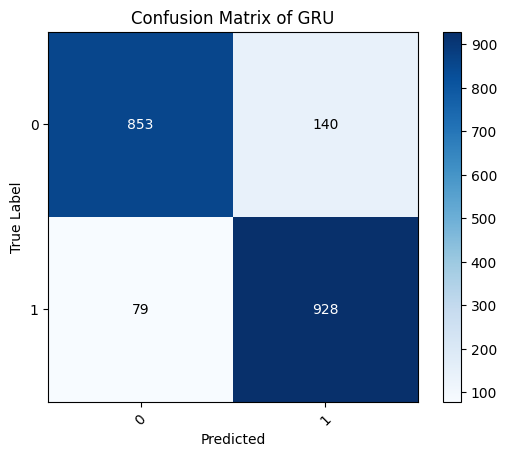

In [ ]:
class_names = ['0', '1']

# Plot the confusion matrix
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix of GRU')
plt.colorbar()

# Add labels
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

# Add text annotations
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, str(conf_matrix[i, j]), ha='center', va='center', color='white' if conf_matrix[i, j] > conf_matrix.max() / 2 else 'black')

plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.show()

**Sum Ensamble**

In [ ]:
# Assume you have a list of model predictions
predictions_model_LSTM = loaded_model_LSTM.predict(X_test)
predictions_model_Bideractional = loaded_model_Bideractional.predict(X_test)
predictions_model_GRU = loaded_model_GRU.predict(X_test)

Ensamble_gred=np.sum([predictions_model_LSTM,predictions_model_Bideractional,predictions_model_GRU],axis=0)

# Convert the ensemble predictions to binary values
Ensamble_gred_binary=np.where(Ensamble_gred >=0.5,1,0)

# Calculate metrcis for each model
accuracy_LSTM= accuracy_score(y_test,np.where(predictions_model_LSTM >=0.5,1,0))
accuracy_Bideractional= accuracy_score(y_test,np.where(predictions_model_Bideractional >=0.5,1,0))
accuracy_GRU= accuracy_score(y_test,np.where(predictions_model_GRU >=0.5,1,0))

precision_LSTM= precision_score(y_test,np.where(predictions_model_LSTM >=0.5,1,0))
precision_Bideractional= precision_score(y_test,np.where(predictions_model_Bideractional >=0.5,1,0))
precision_GRU= precision_score(y_test,np.where(predictions_model_GRU >=0.5,1,0))

recall_LSTM= recall_score(y_test,np.where(predictions_model_LSTM >=0.5,1,0))
recall_Bideractional= recall_score(y_test,np.where(predictions_model_Bideractional >=0.5,1,0))
recall_GRU= recall_score(y_test,np.where(predictions_model_GRU >=0.5,1,0))

f1_LSTM= f1_score(y_test,np.where(predictions_model_LSTM >=0.5,1,0))
f1_Bideractional= f1_score(y_test,np.where(predictions_model_Bideractional >=0.5,1,0))
f1_GRU= f1_score(y_test,np.where(predictions_model_GRU >=0.5,1,0))

# Now, evaluate the performance of the ensemble
accuracy_ensemble = accuracy_score(y_test, Ensamble_gred_binary)
precision_ensemble = precision_score(y_test, Ensamble_gred_binary)
recall_ensemble = recall_score(y_test, Ensamble_gred_binary)
f1_ensemble = f1_score(y_test, Ensamble_gred_binary)

print(f"Ensemble Accuracy: {accuracy_ensemble:.2f}")
print(f"Ensemble precision: {precision_ensemble:.2f}")
print(f"Ensemble recall: {recall_ensemble:.2f}")
print(f"Ensemble f1: {f1_ensemble:.2f}")

63/63 [==============================] - 1s 9ms/step
Ensemble Accuracy: 0.86
Ensemble precision: 0.79
Ensemble recall: 0.98
Ensemble f1: 0.87


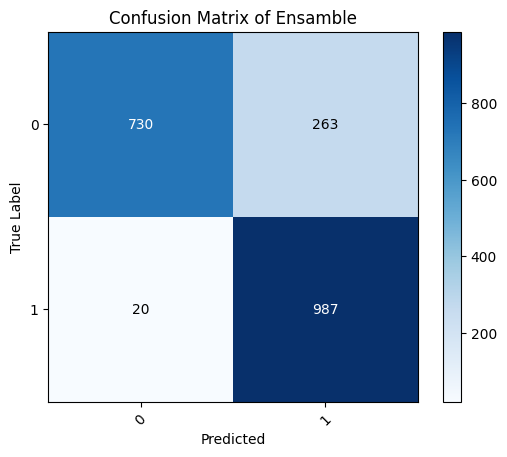

In [ ]:
conf_matrix = confusion_matrix(y_test, Ensamble_gred_binary)

class_names = ['0', '1']

# Plot the confusion matrix
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix of Ensamble')
plt.colorbar()

# Add labels
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

# Add text annotations
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, str(conf_matrix[i, j]), ha='center', va='center', color='white' if conf_matrix[i, j] > conf_matrix.max() / 2 else 'black')

plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.show()

# Save and Load Models from Drive

In [11]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Save the entire model to an HDF5 file
training_model_LSTM.save('/content/gdrive/My Drive/Colab Notebooks/training_model_LSTM.h5')
training_model_Bideractional.save("/content/gdrive/My Drive/Colab Notebooks/training_model_Bideractional.h5")
training_model_GRU.save('/content/gdrive/MyDrive/IMDB_Dataset/training_model_GRU.h5')

In [41]:
# Load the model
loaded_model_LSTM = load_model("/content/drive/MyDrive/IMDB_Dataset/training_model_LSTM.h5")
loaded_model_Bideractional = load_model("/content/drive/MyDrive/IMDB_Dataset/training_model_Bideractional.h5")
loaded_model_GRU = load_model("/content/drive/MyDrive/IMDB_Dataset/training_model_GRU.h5")

In [ ]:
history_dict = history_Bideractional.history

# Save the history dictionary using pickle
with open("/content/gdrive/MyDrive/IMDB_Dataset/history_Bideractional.pkl", 'wb') as file:
    pickle.dump(history_dict, file)

In [ ]:
# history object
history_dict = history_GRU.history

# Save the history dictionary using pickle
with open("/content/gdrive/MyDrive/IMDB_Dataset/history_GRU.pkl", 'wb') as file:
    pickle.dump(history_dict, file)

In [42]:
# Load the history dictionary
with open("/content/drive/MyDrive/IMDB_Dataset/history_Bideractional.pkl", 'rb') as file:
    loaded_history1 = pickle.load(file)

with open("/content/drive/MyDrive/IMDB_Dataset/history_GRU.pkl", 'rb') as file:
    loaded_history2 = pickle.load(file)